# Model 13: Social contagion

original: https://bookdown.org/amesoudi/ABMtutorial_bookdown/model13.html

## Note

- Model 13-15 concern the linked topics of social contagion, social networks and opinion formation.
- これらのモデルは文化進化研究ではなく、社会学や疫学に由来するものだが、文化進化の研究に役立つ。
- 社会的感染モデルは病気の感染だけではなく、アイディアや信念、プロダクト、テクノロジーなど、様々な文化的特性の伝播のモデルとしても使える。
- While this analogy between diseases and ideas has merit, we should be wary of its limitations.
- For example, diseases can be caught with a single exposure to an infected individual, whereas many ideas, skills or beliefs require repeated exposure,
    - such as when persuasion is needed to convince someone of an unusual belief or idea,
    - or when a skill requires a lengthy apprenticeship to master.
- Nevertheless, contagion models provide useful insights into how cultural traits spread through society.

## Model 13a: The SI model

- $S$: Susceptible
- $I$: Infected
- エージェントは$S$もしくは$I$で、well mixed。
- ランダムに出会い、$S$と$I$が出会ったときは、$\beta$ の確率で$I$から$S$に病気 (もしくは何らかの文化的特性) が感染する。$I$同士で出会ったり、$S$同士で出会ったときは、何も起こらない。

In [1]:
using Random
using StatsBase
using Plots

In [2]:
make_outputs(t_max::Int, r_max::Int)::Matrix{Float64} = fill(0.0, t_max, r_max)

function make_agents(N::Int, I_0::Float64)::Vector{String}
    agents = fill("S", N)
    agents[1:Int(round(N*I_0))] .= "I"
    shuffle(agents)
end

function social_transmission!(agents::Vector{String}, N::Int, β::Float64)::Vector{String}
    demonstrators = rand(agents, N)
    infection_flag = agents .== "S" .&& demonstrators .== "I" .&& rand(N) .< β
    agents .= ifelse.(infection_flag, "I", agents)
end

function asocial_transmission!(agents::Vector{String}, N::Int, γ::Float64, from::String, to::String)::Vector{String}
    recovery_flag = agents .== from .&& rand(N) .< γ
    agents .= ifelse.(recovery_flag, to, agents)
end

function plot_results(outputs::Matrix{Float64}, title::String)::Plots.Plot
    _, trials = size(outputs)

    plot(
        outputs, 
        title=title,
        xlabel= "generation",
        ylabel="proportion of Infected agents",
        ylim=(-0.01, 1.01),
        legendtitle="trial",
        legend=false,
        labels=transpose(1:trials)
    )
end;

In [3]:
function SI_model(;
    N::Int = 1000,       # population size
    β::Float64 = 0.1,    # transmissibility (感染力)
    I_0::Float64 = 0.01, # initial frequency of I
    t_max::Int = 150,    # time steps (generation)
    r_max::Int = 10      # trials
)::Nothing
    outputs = make_outputs(t_max, r_max)

    for r in 1:r_max
        agents = make_agents(N, I_0)

        for t in 1:t_max
            if t > 1
                social_transmission!(agents, N, β)
            end
            outputs[t, r] = count(==("I"), agents) / N
        end
    end
    
    display(plot_results(outputs, "SI model"))
end;

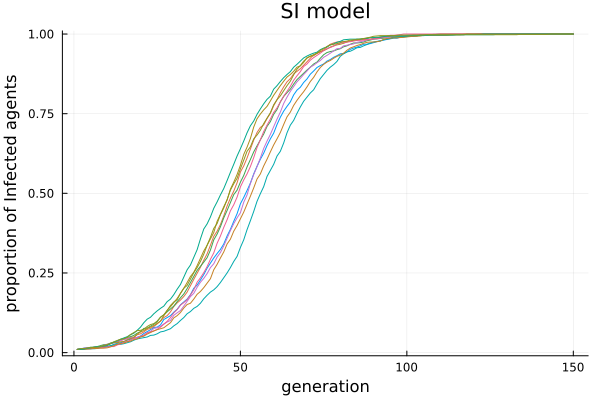

In [4]:
SI_model()

## Model 13b: The SIR model

- $S$: Susceptible
- $I$: Infected
- $R$: Recovered
- エージェントはSもしくはIで、well mixed。
- ランダムに出会い、$S$と$I$が出会ったときは、$\beta$ の確率で$I$から$S$に病気 (もしくは何らかの文化的特性) が感染する。I同士で出会ったり、S同士で出会ったときは、何も起こらない。
- 感染者は $\gamma$ の確率で回復する。感染と違って回復は誰と出会わなくても勝手に起きる。回復した人は二度と感染しない。
- 文化進化では再感染が起こることが多い。再感染が少ない現象としては、カルトへの入信・脱退プロセスとか。

In [5]:
function plot_results(outputs_I::Matrix{Float64}, outputs_R::Matrix{Float64}, title::String)::Plots.Plot
    outputs_S = 1 .- outputs_I .- outputs_R
    plot(title=title, xlabel= "generation", ylabel="proportion of agents", ylim=(-0.01, 1.01), legend=:right)
    plot!(mapslices(mean, outputs_I, dims=2), label="Infected", lw=4, lc=:red)
    plot!(mapslices(mean, outputs_R, dims=2), label="Recovered", lw=4, lc=:blue)
    plot!(mapslices(mean, outputs_S, dims=2), label="Susceptible", lw=4, lc=:gray)
end

function SIR_model(;
    N::Int = 1000,       # population size
    β::Float64 = 0.3,    # transmissibility (感染力)
    γ::Float64 = 0.1,    # 回復率 (New parameter)
    I_0::Float64 = 0.01, # initial frequency of I
    t_max::Int = 100,    # time steps (generation)
    r_max::Int = 10      # trials
)::Nothing
    outputs_I = make_outputs(t_max, r_max)
    outputs_R = make_outputs(t_max, r_max)

    for r in 1:r_max
        agents = make_agents(N, I_0)

        for t in 1:t_max
            if t > 1
                social_transmission!(agents, N, β)
                asocial_transmission!(agents, N, γ, "I", "R")
            end
            outputs_I[t, r] = count(==("I"), agents) / N
            outputs_R[t, r] = count(==("R"), agents) / N
        end
    end
    
    display(plot_results(outputs_I, outputs_R, "SIR model"))
end;

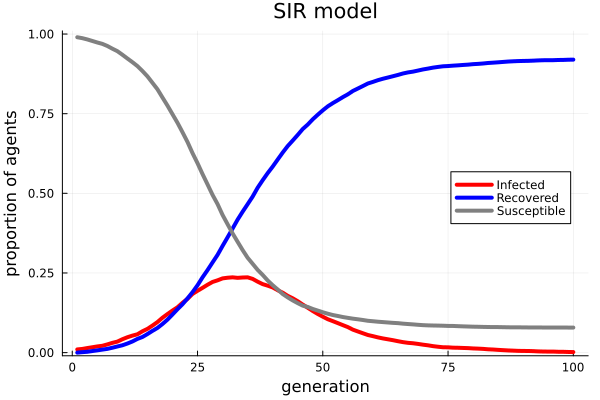

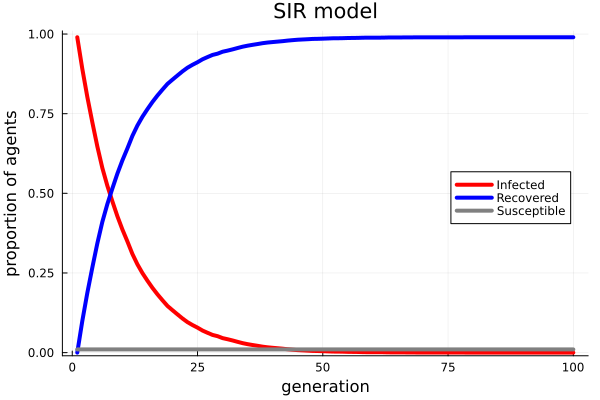

In [6]:
SIR_model()
SIR_model(β = 0.0, I_0 = 0.99)

- SIRモデルのrecoverの部分は、[Model 2b: Biased mutation](https://github.com/mas178/social-simulation/blob/main/Mesoudi2021/model02_unbiased_and_biased_mutation.ipynb) と機能的に等価。

## Model 13c: The SIS model

- The SIS model involves Susceptible individuals becoming Infected, as in the SI model, but now Infected individuals can revert to being Susceptible again.
- 普通の風邪や、ジョギングの習慣などの文化的感染に当てはまるモデル。

In [7]:
function SIS_model(;
    N::Int = 1000,       # population size
    β::Float64 = 0.1,    # transmissibility (感染力)
    α::Float64 = 0.05,   # 回復率 (New parameter)
    I_0::Float64 = 0.01, # initial frequency of I
    t_max::Int = 300,    # time steps (generation)
    r_max::Int = 10      # trials
)::Nothing
    outputs = make_outputs(t_max, r_max)

    for r in 1:r_max
        agents = make_agents(N, I_0)

        for t in 1:t_max
            if t > 1
                social_transmission!(agents, N, β)
                asocial_transmission!(agents, N, α, "I", "S")
            end
            outputs[t, r] = count(==("I"), agents) / N
        end
    end
    
    display(plot_results(outputs, "SIS model"))
end;

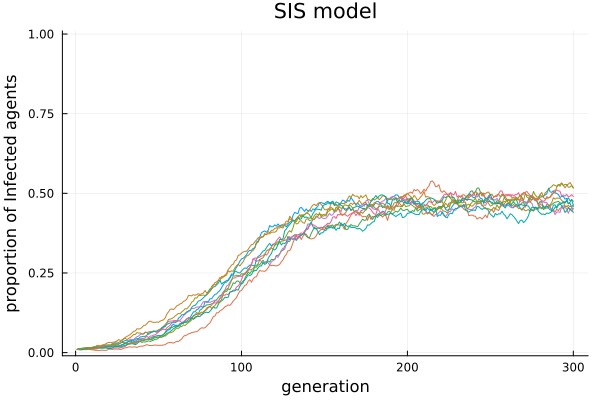

In [8]:
SIS_model()

## Model 13d: The SISa model

- SISa model is more representative of social contagion compared to disease contagion.
- The model assumed that infection can occur not only via social transmission from others, but also asocially (or automatically).
- People can’t invent diseases, but they can invent new ideas, beliefs, products or technologies, or generally decide to adopt a behaviour independently of anyone else.

In [9]:
function SISa_model(;
    N::Int = 1000,       # population size
    β::Float64 = 0.1,    # transmissibility (感染力)
    α::Float64 = 0.05,   # 回復率
    a::Float64 = 0.05,   # probability to mutate from S to I (New parameter)
    I_0::Float64 = 0.01, # initial frequency of I
    t_max::Int = 100,    # time steps (generation)
    r_max::Int = 10      # trials
)::Nothing
    outputs = make_outputs(t_max, r_max)

    for r in 1:r_max
        agents = make_agents(N, I_0)

        for t in 1:t_max
            if t > 1
                social_transmission!(agents, N, β)
                asocial_transmission!(agents, N, α, "I", "S")
                asocial_transmission!(agents, N, a, "S", "I")
            end
            outputs[t, r] = count(==("I"), agents) / N
        end
    end
    
    display(plot_results(outputs, "SISa model"))
end;

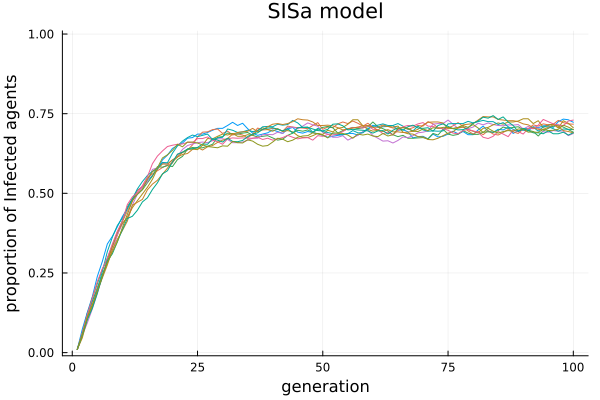

In [10]:
SISa_model()